## Import

In [1]:
import os
import math
import pandas as pd
import random
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.optimize import curve_fit

In [2]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array

## Pauli matrix

In [3]:
j = 1
h = 0.5
hbar = 1
SigmaX = np.array([[0,1],[1,0]])
SigmaY = np.array([[0,-1j],[1j,0]])
SigmaZ = np.array([[1,0],[0,-1]])
sparseSigmaX = sparse.csr_matrix([[0,1],[1,0]]).astype(float)
sparseSigmaY = sparse.csr_matrix([[0,-1j],[1j,0]]).astype(float)
sparseSigmaZ = sparse.csr_matrix([[1,0],[0,-1]]).astype(float)
Sx = hbar/2*SigmaX
Sy = hbar/2*SigmaY
Sz = hbar/2*SigmaZ
sparseSx = hbar/2*sparseSigmaX
sparseSy = hbar/2*sparseSigmaY
sparseSz = hbar/2*sparseSigmaZ
I = np.array([[1,0],[0,1]])
sparseI = sparse.csr_matrix(I).astype(float)

#Htot = np.zeros((2**L,2**L))
#Sxtot = np.zeros((2**L,2**L))
#Sytot = np.zeros((2**L,2**L))
#Sztot = np.zeros((2**L,2**L))

#SzList = []
#SyList = []
#SxList = []


/home/aronton/anaconda3/lib/python3.9/site-packages/scipy/sparse/data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


## One Site

In [4]:
E,V = la.eigh(Sx)
print(Sx @ V[0] -E[0]*V[0])
print(V[0] @ Sx @ V[0])

[0. 0.]
-0.4999999999999999


### $\Xi = \frac{1}{\delta N}$

In [10]:
a = np.zeros((3,3))
aa = csr_matrix(a)
type(aa)

scipy.sparse.csr.csr_matrix

### 多 Sites

In [4]:
def Hamiltonain(L,Sx,Sy,Sz,I,j,hx,hz):

    Sxtot = np.zeros((2**L, 2**L))
    Sytot = np.zeros((2**L, 2**L))
    Sztot = np.zeros((2**L, 2**L))
    Htot = np.zeros((2**L, 2**L))
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = Sx
        y = Sy
        z = Sz
        if(k == 0):
            for i in range(L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            for i in range(k, L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    for i in range(L):
        if i < L-1:
            Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
        else:
            Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]

    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]
    
    return Htot, Sztot, SzList, Sxtot, SxList


def sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,j,hx,hz):

    Sxtot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sytot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sztot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Htot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = sparseSx
        y = sparseSy
        z = sparseSz
        if(k == 0):
            for i in range(L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            for i in range(k, L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    if(hx == 0):
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] 
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] 
    else:
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]


    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]

    return Htot, Sztot, SzList, Sxtot, SxList
    
   

In [5]:
def e(k, h, J):
    return np.sqrt((J/2)**2 + h**2 + J*h*np.cos(k))
def ka(L):
    k_A = []
    for i in range(1,L,2):
        k_A.append((i/L)*np.pi)
        k_A.append(-(i/L)*np.pi)
    return k_A
def kp(L):
    k_P = []
    for i in range(0,L+2,2):
        k_P.append[(1/N)*np.pi]
        k_P.append[-(1/N)*np.pi]
    return k_P
def EE(h, J, L):
    Energy = 0
    for i in ka(L):
        Energy = Energy + e(i,h,J)
    return -0.5*Energy


### 實數 Hamiltonian

In [15]:
Llist = list(range(4,12,2))
hz = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
entropy = np.zeros((len(Llist)))
gap = np.zeros((len(Llist),len(hz)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    L = Llist[l]
    print(L)
    for hz_i in range(len(hz)):
        H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,0,hz[hz_i])
        ee, v = la.eigh(H)
        print(ee[0:2])
        eex, vx = la.eigh(H + 0.01*xtot)
        E[l,hz_i] = ee[0]/L
        E1[l,hz_i] = ee[1]/L
        gap[l,hz_i] = ee[1] - ee[0]
        lamda[l,hz_i] = 1/(ee[1] - ee[0])/L
        SzE[l,hz_i] = v[:,0] @ zlist[0]  @ v[:,0]
        SxE[l,hz_i] = vx[:,0] @ xList[0]  @ vx[:,0]
        # if(hz_i == 26):
        #     rv = np.reshape(v[0], (2**int(L/2),2**int(L/2)))
        #     u, s, vh = np.linalg.svd(rv, full_matrices=True)
        #     for i in range(2**int(L/2)):
        #         entropy[l] = entropy[l] - (s[i])*(s[i])*np.log(s[i]*s[i])



#     plt.plot( hz[:], E[l,:], label = "%d" %L)
#     plt.title("E/N vs hx", fontsize = 25)
#     plt.xlabel("hx", fontsize = 25)
#     plt.ylabel("E/N", fontsize = 25)
#     # plt.xlim(0.4,0.6)
#     plt.legend( fontsize = 25 )
# plt.show()

4
[-1. -1.]
[-1.01014842 -1.00990195]
[-1.04228574 -1.03851648]
[-1.10064218 -1.08309519]
[-1.18896294 -1.14031242]
[-1.30656296 -1.20710678]
[-1.44795866 -1.28102497]
[-1.60629443 -1.36023253]
[-1.77600413 -1.44339811]
[-1.95330631 -1.52956301]
[-2.13577921 -1.61803399]
6


/tmp/ipykernel_628/2943433688.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  SzE[l,hz_i] = v[:,0] @ zlist[0]  @ v[:,0]
/tmp/ipykernel_628/2943433688.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  SxE[l,hz_i] = vx[:,0] @ xList[0]  @ vx[:,0]
/tmp/ipykernel_628/2943433688.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,hz_i] = 1/(ee[1] - ee[0])/L


[-1.5 -1.5]
[-1.51504176 -1.51503401]
[-1.56086091 -1.56038969]
[-1.64075026 -1.63588989]
[-1.76220112 -1.73928254]
[-1.93185165 -1.8660254 ]
[-2.14449914 -2.01071564]
[-2.3862613  -2.16853045]
[-2.64554917 -2.33578167]
[-2.91551158 -2.50984554]
[-3.19234728 -2.68890106]
8
[-2. -2.]
[-2.02005064 -2.02005038]
[-2.08086611 -2.08080222]
[-2.18520861 -2.18373737]
[-2.34130111 -2.32927537]
[-2.56291545 -2.51366975]
[-2.84804991 -2.72898363]
[-3.17405628 -2.96652696]
[-3.52260511 -3.21940224]
[-3.88434335 -3.48286933]
[-4.25454112 -3.75381319]
10
[-2.5 -2.5]
[-2.52506314 -2.52506313]
[-2.60104723 -2.6010382 ]
[-2.73082864 -2.73036332]
[-2.92273393 -2.91607682]
[-3.19622661 -3.15687576]
[-3.55443763 -3.44305455]


KeyboardInterrupt: 

In [41]:
Llist = list(range(4,12,2))
hz = np.linspace(0,1,51)
E = np.zeros((len(Llist),len(hz)))
entropy = np.zeros((len(Llist)))
gap = np.zeros((len(Llist),len(hz)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    L = Llist[l]
    H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,0,0.5)
    ee, v = la.eigh(H)
    rv = np.reshape(v[:,0], (2**int(L//2),2**int(L/2)))
    u, s, vh = np.linalg.svd(rv, full_matrices=True)
    for i in range(2**int(L/2)):
        entropy[l] = entropy[l] - (s[i])*(s[i])*np.log(s[i]*s[i])


[0.52186902 0.58773791 0.63509567 0.67201476]
[1.3862943611198906, 1.791759469228055, 2.0794415416798357, 2.302585092994046]


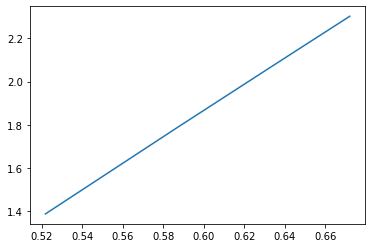

In [42]:
Llog = []
for i in Llist:
    Llog.append(np.log(i))

plt.plot(entropy,Llog)

print(entropy)
print(Llog)

In [39]:
for i in range(2):
    print("i:",i)

i: 0
i: 1


In [33]:
Llist = np.linspace(4,10,4,dtype=int)
hz = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros(len(Llist))
print(np.shape(entropy))
gap = np.zeros((len(Llist),len(hz)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))
print(Llist)
print("len(Llist)/2+1",len(Llist)//2+1)
# fig, ax = plt.subplots(figsize=(16,16))
# for l in range(len(Llist)):
#     print("l:",l)
l = 3
print(Llist[3])
Na = np.linspace(0,Llist[l],Llist[l]+1,dtype = int)
entropy = np.zeros(len(Na))
print(Na)
for na in range(len(Na)):
    print("na:",na)
    L = Llist[l]
    H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,0,0.5)
    ee, v = la.eigh(H)
    print("v[:,0]",v[:,0])
    rv = np.reshape(v[:,0], (2**int(Na[na]),2**int(L-Na[na])))
    u, s, vh = np.linalg.svd(rv, full_matrices=True)
    print("s:")
    print(s)
    for svalue in s:
        print("i:",i)
        entropy[na] = entropy[na] - (svalue)*(svalue)*np.log(svalue*svalue)


(4,)
[ 4  6  8 10]
len(Llist)/2+1 3
10
[ 0  1  2  3  4  5  6  7  8  9 10]
na: 0
v[:,0] [5.80653851e-01+0.j 3.33066907e-16+0.j 3.33066907e-16+0.j ...
 1.57350395e-18+0.j 1.84701483e-18+0.j 2.37847029e-03+0.j]
s:
[1.]
i: 31
na: 1
v[:,0] [5.80653851e-01+0.j 3.33066907e-16+0.j 3.33066907e-16+0.j ...
 1.57350395e-18+0.j 1.84701483e-18+0.j 2.37847029e-03+0.j]
s:
[0.90533014 0.42470853]
i: 31
i: 31
na: 2
v[:,0] [5.80653851e-01+0.j 3.33066907e-16+0.j 3.33066907e-16+0.j ...
 1.57350395e-18+0.j 1.84701483e-18+0.j 2.37847029e-03+0.j]
s:
[0.87891884 0.46624455 0.08885823 0.04713708]
i: 31
i: 31
i: 31
i: 31
na: 3
v[:,0] [5.80653851e-01+0.j 3.33066907e-16+0.j 3.33066907e-16+0.j ...
 1.57350395e-18+0.j 1.84701483e-18+0.j 2.37847029e-03+0.j]
s:
[0.86602311 0.48225025 0.11445755 0.06373639 0.01438431 0.00800999
 0.0019011  0.00105864]
i: 31
i: 31
i: 31
i: 31
i: 31
i: 31
i: 31
i: 31
na: 4
v[:,0] [5.80653851e-01+0.j 3.33066907e-16+0.j 3.33066907e-16+0.j ...
 1.57350395e-18+0.j 1.84701483e-18+0.j 2.378470

KeyboardInterrupt: 

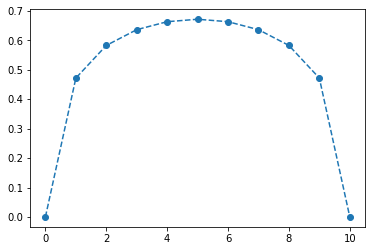

In [53]:
plt.plot(Na,entropy, "--o")

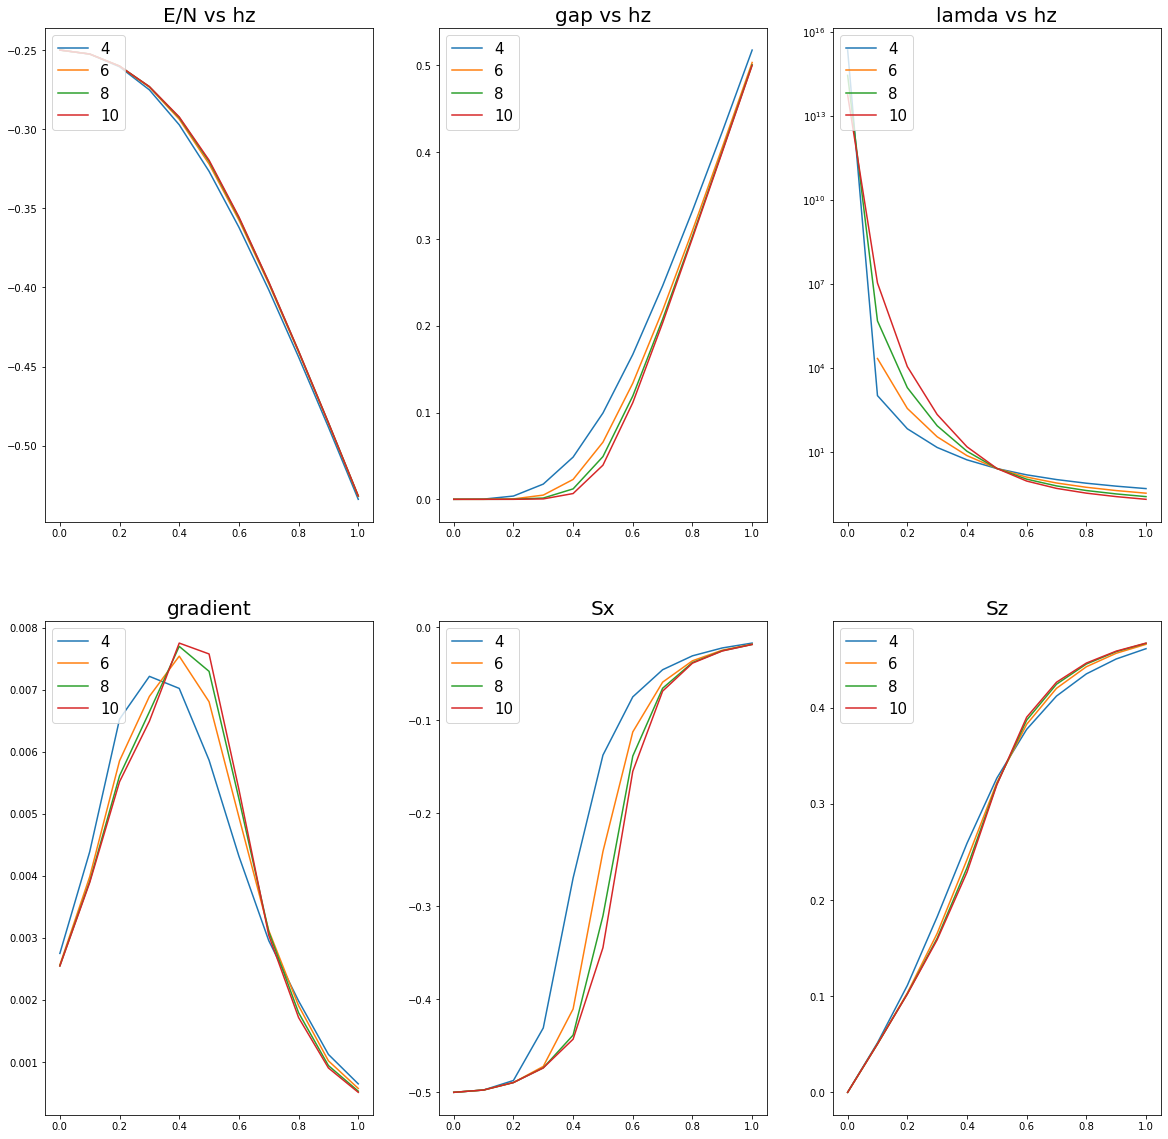

In [92]:
fig, ax = plt.subplots(2,3,figsize=(20,20))
for l in range(len(Llist)):
    L = Llist[l]
    ax[0][0].plot(hz[:],E[l,:], label = "%d" %L)
    ax[0][0].set_title("E/N vs hz", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hz[:],gap[l,:], label = "%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[0][2].plot(hz[:],lamda[l,:], label = "%d" %L)
    ax[0][2].set_title("lamda vs hz", fontsize = 20)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_yscale('log')

    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E[l,:])), label = "%d" %L)
    ax[1][0].set_title("gradient", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hz[:], SxE[l,:], label = "%d" %L)
    ax[1][1].set_title("Sx", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    ax[1][2].plot(hz[:], SzE[l,:], label = "%d" %L)
    ax[1][2].set_title("Sz", fontsize = 20)
    ax[1][2].legend(loc = "upper left", fontsize=15)
plt.show()

In [5]:
Llist = list(range(4,12,2))
hz = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
entropy = np.zeros((len(Llist)))
gap = np.zeros((len(Llist),len(hz)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
L = 4
vt = np.zeros((2**4,2**4))
shift = np.zeros((2**4,2**4))

H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,0,0.5)
ee, v = la.eigh(H)
for k in range(len(v[0,:])):
    rv = np.reshape(v[:,k],(2,2,2,2))
    rvt = np.transpose(rv,(3,0,1,2))
    vt[:,k] = np.reshape(rvt,(16))

for i in range(2**4):
    for j in range(2**4):
        a = v[:,i] @ vt[:,j]
        if(a < np.exp(-10)):
            shift[i,j] = 0
        else:
            shift[i,j] = a
# np.set_printoptions(precision=2,linewidth=1000)
# print(shift)
np.set_printoptions(precision=2,linewidth=1000)
print(shift @ shift @ shift @ shift)

# E[l,hz_i] = ee[0]/L
# E1[l,hz_i] = ee[1]/L
# gap[l,hz_i] = ee[1] - ee[0]
# lamda[l,hz_i] = 1/(ee[1] - ee[0])/L
# SzE[l,hz_i] = v[:,0] @ zlist[0]  @ v[:,0]
# SxE[l,hz_i] = vx[:,0] @ xList[0]  @ vx[:,0]

[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.05 0.18 0.   0.15 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.15 0.05 0.13 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.

/tmp/ipykernel_22815/3755959243.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  vt[:,k] = np.reshape(rvt,(16))
/tmp/ipykernel_22815/3755959243.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  shift[i,j] = a


### Real Hamiltoian Using Sparse

In [12]:
Llist = np.linspace(4,14,(14-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,11)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    L = Llist[l]
    entropy.append(np.zeros((L+1,len(hz))))
    for hz_i in range(len(hz)):
        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,hz[hz_i])
        ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        # eg, vg = sparse.linalg.eigsh(SHtot,1,which="SA")
        ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")
        index = np.argsort(ee)
        ee = sorted(ee)
        # print(index)
        # print(index[0])
        # print(index[1])
        E0[l,hz_i] = ee[0]/L
        E1[l,hz_i] = ee[1]/L
        gap[l,hz_i] = ee[1] - ee[0]
        lamda[l,hz_i] = 1/gap[l,hz_i]/L
        SzE[l,hz_i] = Sv[:,index[0]] @ Szlist[0] @ Sv[:,index[0]] 
        SxE[l,hz_i] = Svx[:,index[0]] @ Sxlist[0] @ Svx[:,index[0]] 
        # print(type(Sxlist[0][1,1]))
        # print("v",v)
        # print("v",v[:,index[0]])
        Na = np.linspace(0,L,L+1,dtype = int)
        SHtot = Sztot = Szlist = Sxtot = Sxlist =0
        for na in range(len(Na)):
            rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            u, s, vh = np.linalg.svd(rv)
            for svalue in s:
                entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)

4


/tmp/ipykernel_688/3339110205.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  Slamda[l,hz_i] = 1/Sgap[l,hz_i]/L


6
8
10
12
14
16


IndexError: list index out of range

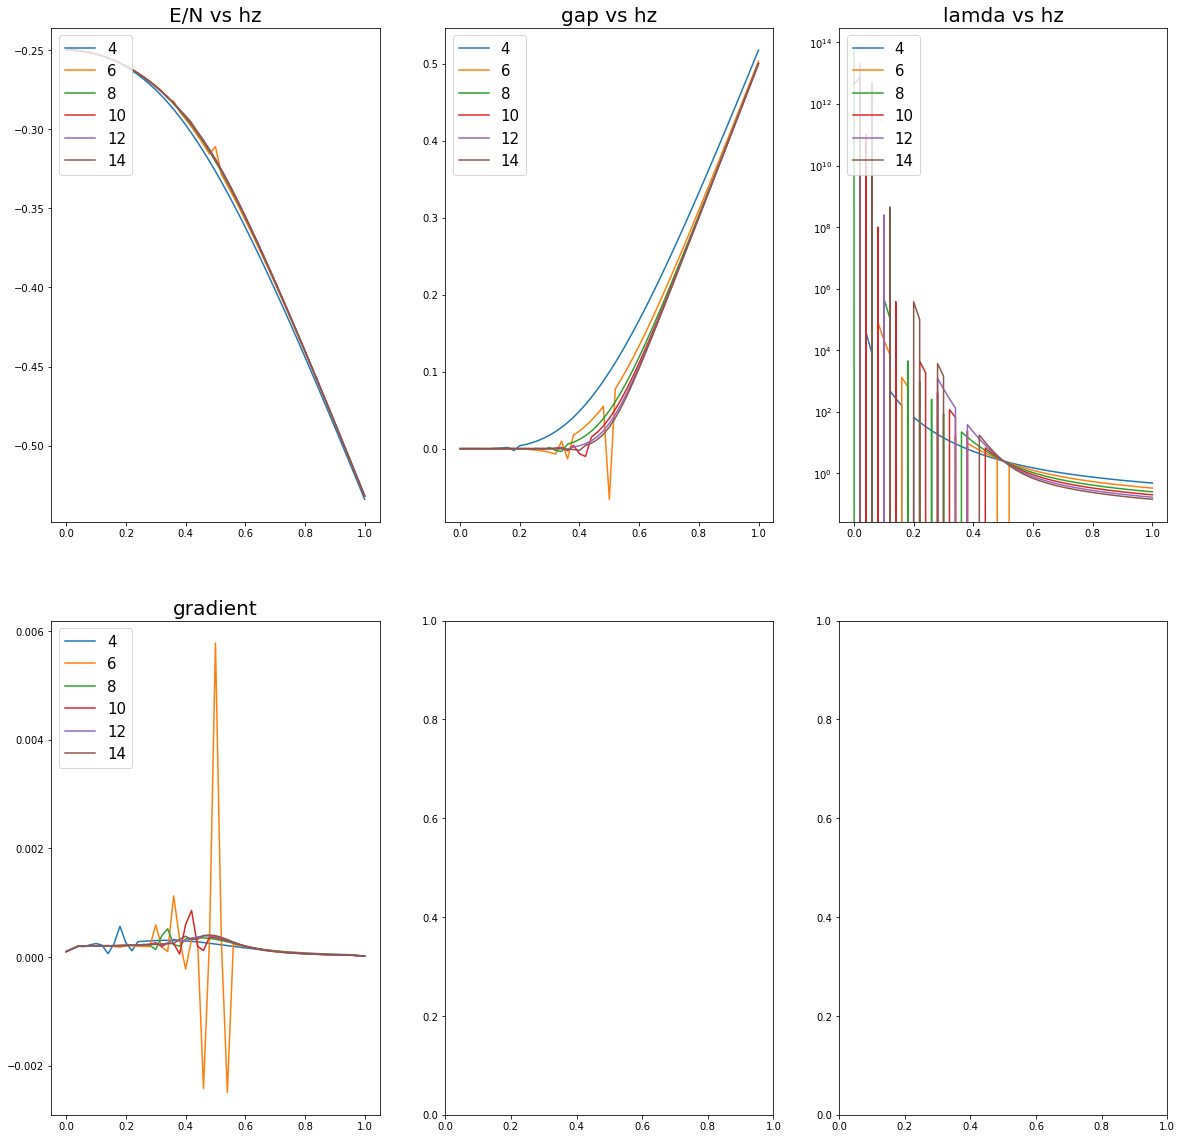

In [18]:
fig, ax = plt.subplots(2,4,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    ax[0][0].plot(hz[:],E0[l,:], "-X", label = "%d" %L)
    ax[0][0].set_title("$E_0$/N vs hz", fontsize = 20)
    ax[0][0].set_ylabel("$E_0$/N", fontsize = 20)
    ax[0][0].set_xlabel("hz", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hz[:],gap[l,:], "-X", label = "%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 20)
    ax[0][1].set_ylabel("gap", fontsize = 20)
    ax[0][1].set_xlabel("hz", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[0][2].plot(hz[:],lamda[l,:], "-X", label = "%d" %L)
    ax[0][2].set_title("Corr length/N vs hz", fontsize = 20)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 20)
    ax[0][2].set_xlabel("hz", fontsize = 20)
    ax[0][2].set_yscale('log')

    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E0[l,:])), "-X", label = "%d" %L)
    ax[1][0].set_title("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_ylabel("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_xlabel("hz", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hz[:], SxE[l,:], "-X", label = "%d" %L)
    ax[1][1].set_title("<Sx>", fontsize = 20)
    ax[1][1].set_ylabel("<Sx>", fontsize = 20)
    ax[1][1].set_xlabel("hz", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    ax[1][2].plot(hz[:], SzE[l,:], "-X", label = "%d" %L)
    ax[1][2].set_title("<Sz>", fontsize = 20)
    ax[1][2].set_ylabel("<Sz>", fontsize = 20)
    ax[1][2].set_xlabel("hz", fontsize = 20)
    ax[1][2].legend(loc = "upper left", fontsize=15)

    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]


for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][3].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][3].set_ylabel("Entropy", fontsize = 20)
        ax[0][3].set_xlabel("log(L)", fontsize = 20)
        ax[0][3].set_title("Entropy vs log(L)", fontsize = 20)
        ax[0][3].legend(loc = "upper left", fontsize=15)
        ax[0][3].set_xscale('log')
    
for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    ax[1][3].plot(Na[:],entropy[l][:,(len(hz)+1)//2], "-X", label = "%d" %(Llist[l]))
    ax[1][3].set_ylabel("Entropy", fontsize = 20)
    ax[1][3].set_xlabel("Na", fontsize = 20)
    ax[1][3].set_title("Entropy vs Na", fontsize = 20)
    ax[1][3].legend(loc = "upper left", fontsize=15)


plt.show()

In [ ]:
Llist = np.linspace(4,14,(14-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,11)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
# for l in range(len(Llist)):
    L = 4
    SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,0.5)
    ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
    ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")
    index = np.argsort(ee)
    ee = sorted(ee)
    # print(index)
    # print(index[0])
    # print(index[1])
    E0[l,hz_i] = ee[0]/L
    E1[l,hz_i] = ee[1]/L
    gap[l,hz_i] = ee[1] - ee[0]
    lamda[l,hz_i] = 1/gap[l,hz_i]/L
    SzE[l,hz_i] = Sv[:,index[0]] @ Szlist[0] @ Sv[:,index[0]] 
    SxE[l,hz_i] = Svx[:,index[0]] @ Sxlist[0] @ Svx[:,index[0]] 
    # print(type(Sxlist[0][1,1]))
    # print("v",v)
    # print("v",v[:,index[0]])
    Na = np.linspace(0,L,L+1,dtype = int)


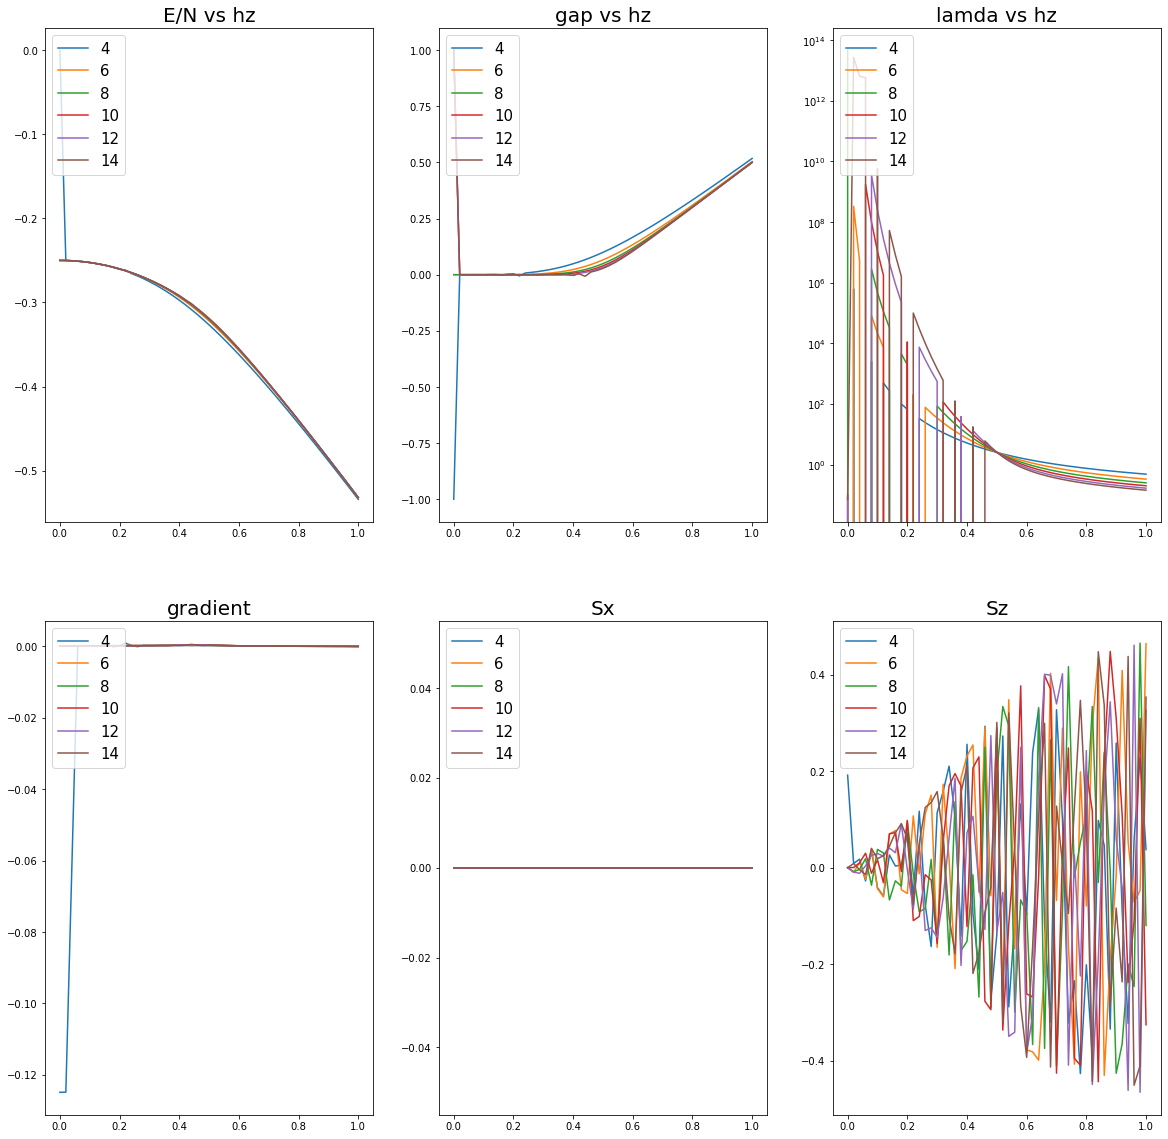

In [23]:

fig, ax = plt.subplots(2,3,figsize=(20,20))
for l in range(len(Llist)):
    L = Llist[l]
    ax[0][0].plot(hz[:],E[l,:], label = "%d" %L)
    ax[0][0].set_title("E/N vs hz", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hz[:],gap[l,:], label = "%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[0][2].plot(hz[:],lamda[l,:], label = "%d" %L)
    ax[0][2].set_title("lamda vs hz", fontsize = 20)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_yscale('log')

    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E[l,:])), label = "%d" %L)
    ax[1][0].set_title("gradient", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hz[:], SxE[l,:], label = "%d" %L)
    ax[1][1].set_title("Sx", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    ax[1][2].plot(hz[:], SzE[l,:], label = "%d" %L)
    ax[1][2].set_title("Sz", fontsize = 20)
    ax[1][2].legend(loc = "upper left", fontsize=15)
plt.show()

In [21]:
Linverse = [1/4,1/6,1/8,1/10]
# for i in range(len(Linverse)):
#     Linverse.append(1/Llist[i])
#     print("L:", Llist[0])

# print(Llist)
# print(Linverse)
for i in list(range(23,28,1)):
    print(gap[:,i])
    poly = np.polyfit(Linverse,gap[:,i],1)
    x = np.linspace(0,0.25,10)
    y = poly[0]*x + poly[1]
    plt.plot(Linverse,gap[:,i],marr[0],markersize = 10 ,label = "h = %.2f,%.2f" %(hz[i],poly[1]) )
    plt.plot(x,y,marr[2],markersize = 5)
    plt.legend()

[-0.46 -2.76 -3.68  4.6   5.52 -6.44 -7.36]


TypeError: expected x and y to have same length

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


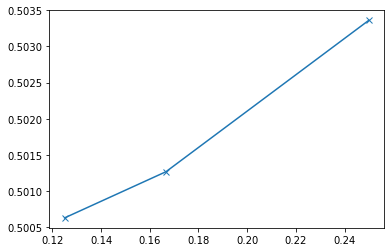

In [101]:
hzlist = [i for i in range (20,30)]

hc = np.zeros(len(Llist)-1)
print(hzlist)

# for i in range(len(Llist)):
#     plt.plot(hzlist[:],lamda[i,hzlist[:]])
for i in range(len(Llist)-1):
    for hz_i in hzlist:
        if((lamda[i+1,hz_i] - lamda[i,hz_i])*(lamda[i+1,hz_i+1] - lamda[i,hz_i+1]) < 0):
            p1 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i,hz_i],lamda[i,hz_i+1]],1)
            p2 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i+1,hz_i],lamda[i+1,hz_i+1]],1)
            hc[i] = np.roots(p1 -p2)


plt.plot(Linverse[0:3],hc[:],marr[1])

    

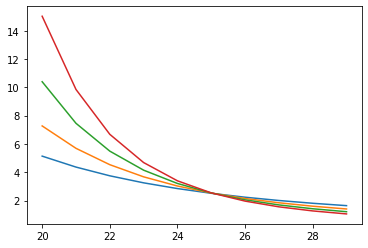

In [100]:
for i in range(len(Llist)):
    plt.plot(hzlist[:],lamda[i,hzlist[:]])

4


/home/aronton/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

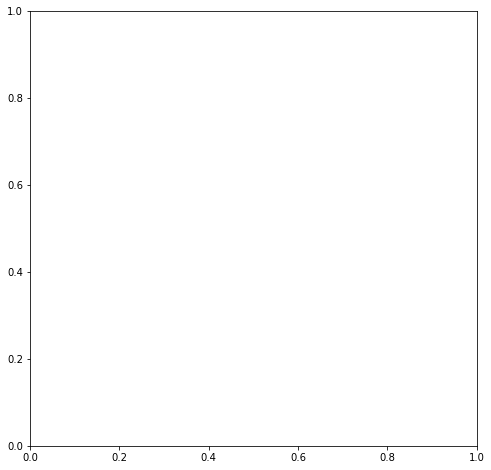

In [8]:
Llist = list(range(4,12,2))
lamlist = np.linspace(0.1,0.3,21)
E = np.zeros((len(Llist),len(lamlist)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(lamlist)))


fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    print(L)
    for lam in range(len(lamlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,lamlist[lam],1)
        ee, v = la.eig(H)
        ee = np.sort_complex(ee)
        #print(ee[:2])
        # E[l,h] = ee[0].real/L
        E[l,lam] = (ee[1].real - ee[0].real)
        #print(lamda)
        #Eex[l,h] = EE(hlist[h], 1, L)/L
    plt.plot( lamlist, E[l,:], label = "%d" %L )
    plt.title("xi/N vs hx")
    plt.xlabel("hx")
    plt.ylabel("gap")
    # plt.xlim(0.4,0.6)
    plt.legend()
plt.show()


4
6


<ipython-input-95-f0a7ca53cb3d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  E0[l,lam] = (1/np.real(ee[1] - ee[0])/L)
<ipython-input-95-f0a7ca53cb3d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  E0[l,lam] = (1/np.real(ee[1] - ee[0])/L)


8


<ipython-input-95-f0a7ca53cb3d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  E0[l,lam] = (1/np.real(ee[1] - ee[0])/L)


10


<ipython-input-95-f0a7ca53cb3d>:20: RuntimeWarning: divide by zero encountered in double_scalars
  E0[l,lam] = (1/np.real(ee[1] - ee[0])/L)


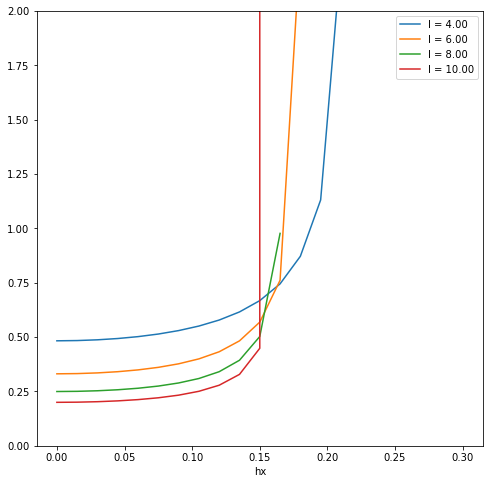

In [95]:
Llist = list(range(4,12,2))
lamlist = np.linspace(0,0.3,21)
E0 = np.zeros((len(Llist),len(lamlist)))
E1 = np.zeros((len(Llist),len(lamlist)))

# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(lamlist)))


fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    print(L)
    for lam in range(len(lamlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,lamlist[lam],1)
        ee, v = la.eig(H)
        ee = np.sort_complex(ee)
        #print(ee[:2])
        # E[l,h] = ee[0].real/L
        E0[l,lam] = (1/np.real(ee[1] - ee[0])/L)
        # E1[l,lam] = /L
        #print(lamda)
        #Eex[l,h] = EE(hlist[h], 1, L)/L
    plt.plot( lamlist, E0[l,:], label = "l = %.2f" %L )
    # plt.plot( lamlist, E1[l,:], marr = l + 1, label = "iIm(E1)/%d" %L )
    plt.xlabel("hx")
    # plt.yscale("log")
    plt.ylim(0,2)
    plt.legend()
plt.show()


4
6
8


<ipython-input-14-709bf3f9c6fc>:20: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,h] = 1/ (ee[1] - ee[0])*1/L


10


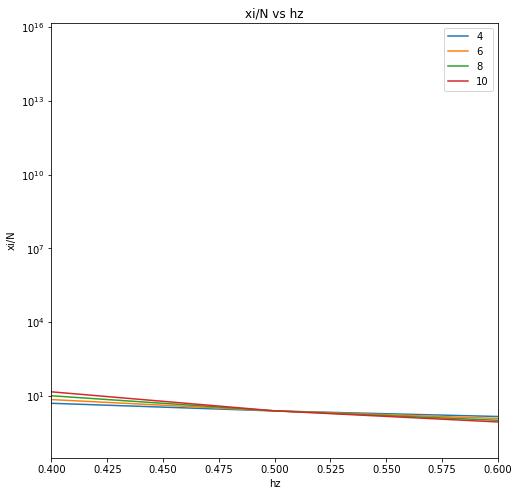

In [14]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hlist)))
# Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hlist)))


fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    print(L)
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h],0)
        ee, v = la.eigh(H)
        #print(ee[:2])
        E[l,h] = ee[0]/L
        lamda[l,h] = 1/ (ee[1] - ee[0])*1/L
        #print(lamda)
        #Eex[l,h] = EE(hlist[h], 1, L)/L
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("xi/N vs hz")
    plt.xlabel("hz")
    plt.ylabel("xi/N")
    plt.yscale("log")
    plt.xlim(0.4,0.6)
    plt.legend()
plt.show()

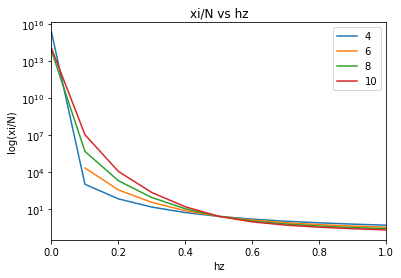

In [29]:
for l in range(len(Llist)):
    L = Llist[l]
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("xi/N vs hz")
    plt.xlabel("hz")
    plt.ylabel("log(xi/N)")
    plt.yscale("log")
    plt.xlim(0,1)
    plt.legend()
plt.show()

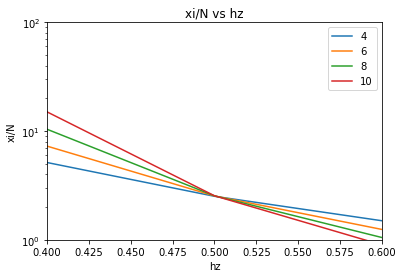

In [33]:
for l in range(len(Llist)):
    L = Llist[l]
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("xi/N vs hz")
    plt.xlabel("hz")
    plt.ylabel("xi/N")
    plt.yscale("log")
    plt.ylim(1,100)
    plt.xlim(0.4,0.6)
    plt.legend()
plt.show()

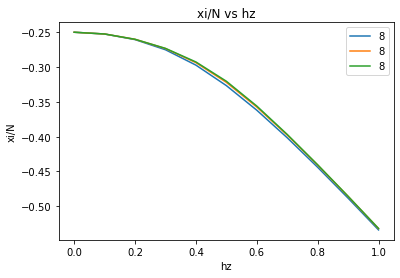

In [16]:
for l in range(len(Llist)):
    plt.plot( hlist, E[l,:], label = "%d" %L )
    plt.title("xi/N vs hz")
    plt.xlabel("hz")
    plt.ylabel("xi/N")
    plt.legend()
plt.show()

In [ ]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,21)
E = np.zeros((len(Llist),len(hlist)))
Eex = np.zeros((len(Llist),len(hlist)))
lamda = np.zeros((len(Llist),len(hlist)))


fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        ee, v = la.eigh(Htot)
        E[l,h] = ee[0]/L
        lamda[l,h] = 1/ (ee[1] - ee[0])*1/L
        #print(lamda)
        #Eex[l,h] = EE(hlist[h], 1, L)/L
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("xi/N vs hz")
    plt.xlabel("hz")
    plt.ylabel("xi/N")
    plt.xlim(0.4,0.6)
    plt.legend()
plt.show()

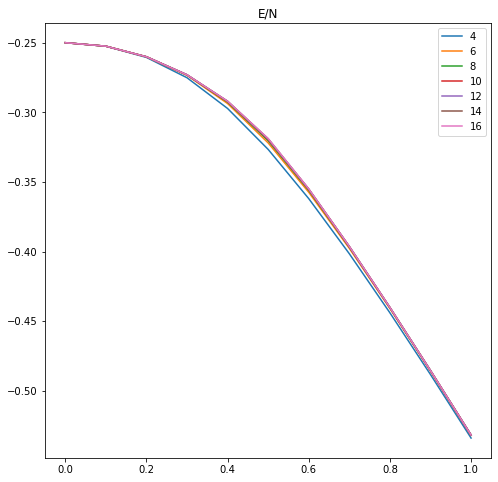

[[-0.25       -0.25253711 -0.26057143 -0.27516055 -0.29724074 -0.32664074
  -0.36198966 -0.40157361 -0.44400103 -0.48832658 -0.5339448 ]
 [-0.25       -0.25250696 -0.26014349 -0.27345838 -0.29370019 -0.32197528
  -0.35741652 -0.39771022 -0.44092486 -0.4859186  -0.53205788]
 [-0.25       -0.25250633 -0.26010826 -0.27315108 -0.29266264 -0.32036443
  -0.35600624 -0.39675703 -0.44032564 -0.48554292 -0.53181764]
 [-0.25       -0.25250631 -0.26010472 -0.27308286 -0.29227339 -0.31962266
  -0.35544376 -0.39646284 -0.44018176 -0.48547107 -0.53178022]
 [-0.25       -0.25250631 -0.26010433 -0.27306594 -0.29210718 -0.31922073
  -0.35518665 -0.39636074 -0.44014312 -0.48545572 -0.53177371]
 [-0.25       -0.25250631 -0.26010428 -0.27306143 -0.29203037 -0.31897872
  -0.35505892 -0.39632262 -0.44013198 -0.48545221 -0.5317725 ]
 [-0.25       -0.25250631 -0.26010427 -0.27306017 -0.29199294 -0.31882179
  -0.35499183 -0.39630766 -0.4401286  -0.48545136 -0.53177227]]


In [11]:
Llist = list(range(4,18,2))
hlist = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hlist)))

fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hlist)):
        SHtot, Szlist, Sztot, Sxlist, Sxtot  = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,hlist[h])
        e, v = sparse.linalg.eigsh(SHtot,1,which = "SA")
        E[l,h] = e/L
    plt.plot( hlist, E[l,:], label = "%d" %L )
    plt.title("E/N")
    plt.legend()
plt.show()
print(E)



ee0 -2.000000000000002
ee1 -2.0000000000000004
ee0 -2.0200506397778395
ee1 -2.020050376160243
ee0 -2.0808661136172297
ee1 -2.080802216990642
ee0 -2.1852086135724815
ee1 -2.183737370315094
ee0 -2.3413011141092985
ee1 -2.329275368155864
ee0 -2.5629154477415064
ee1 -2.5136697460629227
ee0 -2.8480499128813723
ee1 -2.7289836272327297
ee0 -3.1740562790291342
ee1 -2.9665269589793684
ee0 -3.522605109948868
ee1 -3.219402243522973
ee0 -3.8843433519313644
ee1 -3.4828693280704264
ee0 -4.254541117570138
ee1 -3.7538131938197465


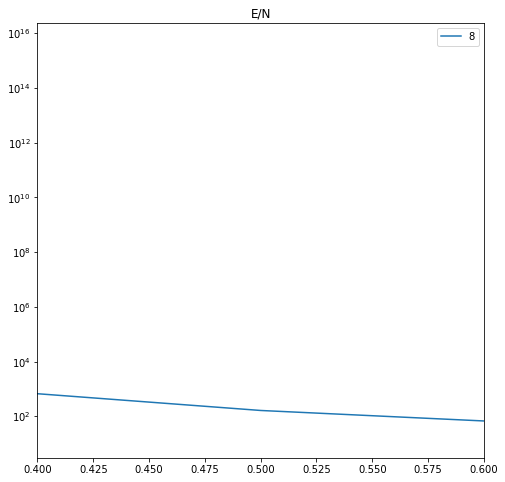

In [108]:
Llist = list(range(8,10,2))
hlist = np.linspace(0,1,11)
lamda = np.zeros((len(Llist),len(hlist)))

fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        ee, v = la.eigh(Htot)
        print("ee0",ee[0])
        print("ee1",ee[1])
        lamda[l,h] = L/(ee[1]-ee[0])
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("E/N")
    plt.legend()
plt.yscale("log")
plt.xlim(0.4,0.6)
plt.show()


SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>
SHtot: <class 'scipy.sparse.csr.csr_matrix'>
SSxtot: <class 'scipy.sparse.csr.csr_matrix'>

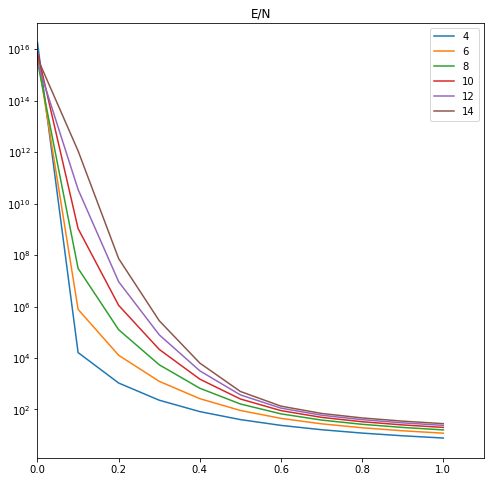

In [63]:
Llist = list(range(4,16,2))
hlist = np.linspace(0,1,11)
lamda = np.zeros((len(Llist),len(hlist)))
#E1 = np.zeros((len(Llist),len(hlist)))

fig, ax = plt.subplots(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        SHamiltonain(L,SSx,SSy,SSz,SI,1,hlist[h])
        e, v = sparse.linalg.eigsh(SHtot,2,which = "SA")
        lamda[l,h] = Llist[l]/(e[1]-e[0])
    plt.plot( hlist, lamda[l,:], label = "%d" %L )
    plt.title("E/N")
    plt.legend()
    plt.xlim(0,1.1)
plt.yscale("log")
plt.show()


In [ ]:
k = []
for i in range(1,L.2):
    k.append(i*np.pi/L)


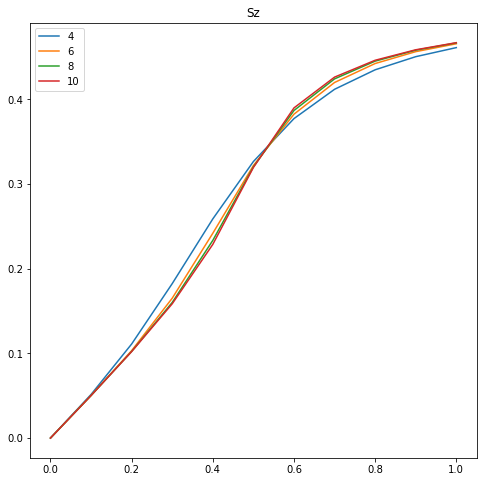

In [44]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
SzE = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))

for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        e, v = la.eigh(Htot)
        SzE[l,h] = v[:,0] @ SzList[0]  @ v[:,0]
    plt.plot( hlist, SzE[l,:], label = "%d" %L )
    plt.title("Sz")
    plt.legend()
plt.show()

In [16]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
SzE = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))

for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h],0)
        e, v = la.eigh(H)
        SzE[l,h] = v[:,0] @ SzList[0]  @ v[:,0]
    plt.plot( hlist, SzE[l,:], label = "%d" %L )
    plt.title("Sz")
    plt.legend()
plt.show()

NameError: name 'SzList' is not defined

<Figure size 576x576 with 0 Axes>

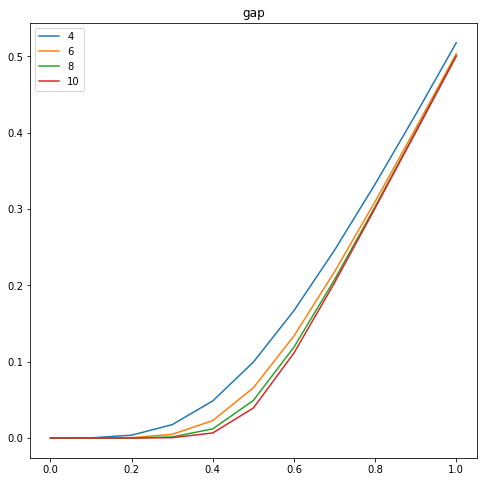

In [45]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h],0)
        e, v = la.eigh(H)
        E[l,h] = e[1] - e[0]
    plt.plot( hlist, E[l,:], label = "%d" %L )
    plt.title("gap")
    plt.legend()
plt.show()

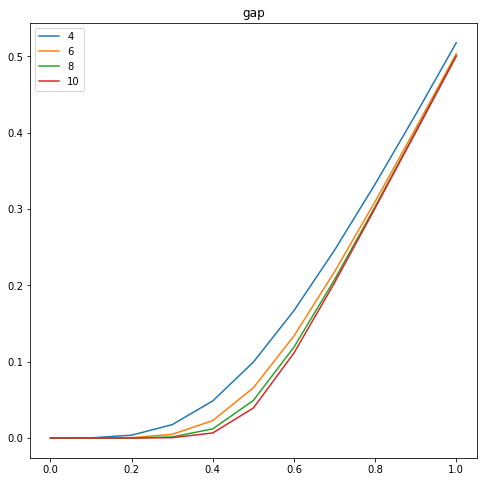

In [17]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h],0)
        e, v = la.eigh(H)
        E[l,h] = e[1] - e[0]
    plt.plot( hlist, E[l,:], label = "%d" %L )
    plt.title("gap")
    plt.legend()
plt.show()

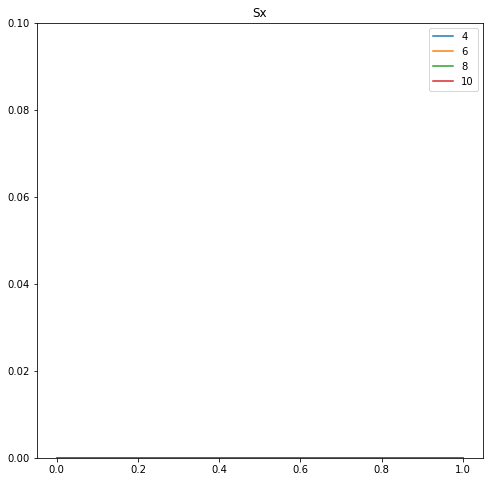

In [46]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
SxE = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        e, v = la.eigh(Htot)
        SxE[l,h] = v[:,0] @ SxList[0]  @ v[:,0]
    plt.plot( hlist, np.abs(SxE[l,:]), label = "%d" %L )
    plt.title("Sx")
    plt.ylim(0,0.1)
    plt.legend()


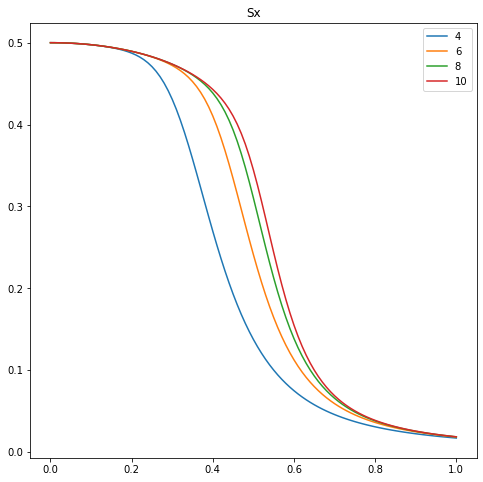

In [53]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,101)
SxE = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        e, v = la.eigh(Htot + 0.01*Sxtot)
        SxE[l,h] = v[:,0] @ SxList[0]  @ v[:,0]
    plt.plot( hlist, np.abs(SxE[l,:]), label = "%d" %L )
    plt.title("Sx")
    plt.legend()

KeyboardInterrupt: 

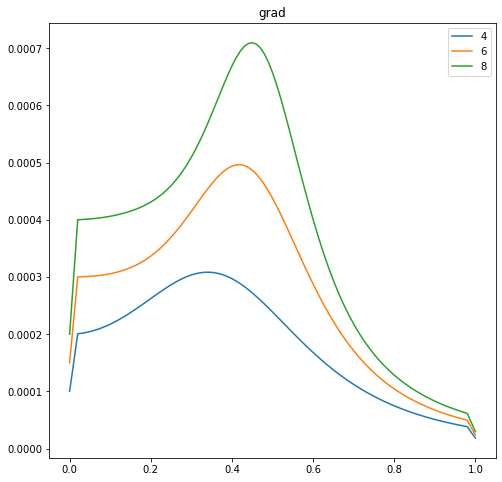

In [102]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,101)
E = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h])
        e, v = la.eigh(Htot)
        E[l,h] = e[0]
    plt.plot( hlist, -np.gradient(np.gradient(E[l,:])), label = "%d" %L )
    plt.title("grad")
    plt.legend()

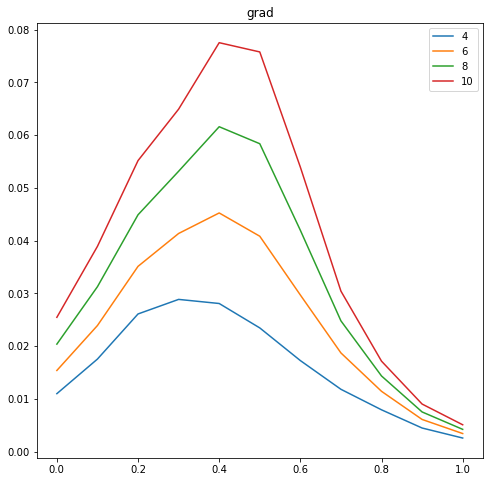

In [19]:
Llist = list(range(4,12,2))
hlist = np.linspace(0,1,11)
E = np.zeros((len(Llist),len(hlist)))

plt.figure(figsize=(8,8))
for l in range(len(Llist)):
    L = Llist[l]
    Sxtot = np.zeros((2**L,2**L))
    Sytot = np.zeros((2**L,2**L))
    Sztot = np.zeros((2**L,2**L))
    for h in range(len(hlist)):
        H = Hamiltonain(L,Sx,Sy,Sz,I,1,hlist[h],0)
        e, v = la.eigh(H)
        E[l,h] = e[0]
    plt.plot( hlist, -np.gradient(np.gradient(E[l,:])), label = "%d" %L )
    plt.title("grad")
    plt.legend()

In [20]:
Hamiltonain(4,Sx,Sy,Sz,I,1.1,0.6)
e, v = la.eigh(Htot)
#print(e)
#print(v)
print(e[0])
print(v[0])
print(e[0]*v[:,0])
print(Htot@v[:,0])

-1.5051374446884687
[-5.54696126e-01 -6.47248914e-01 -4.14152098e-01 -1.44070444e-15
  1.88595639e-17  4.10504796e-17 -2.98721565e-17  7.97579289e-18
  1.20320702e-17 -2.17648971e-17  2.84725908e-01 -2.31787132e-16
  8.21045001e-19  1.15537281e-01 -5.98875092e-17 -8.62634605e-02]
[0.83489391 0.28187232 0.28187232 0.22472817 0.28187232 0.12983836
 0.22472817 0.28187232 0.28187232 0.22472817 0.12983836 0.28187232
 0.22472817 0.28187232 0.28187232 0.83489391]
[0.83489391 0.28187232 0.28187232 0.22472817 0.28187232 0.12983836
 0.22472817 0.28187232 0.28187232 0.22472817 0.12983836 0.28187232
 0.22472817 0.28187232 0.28187232 0.83489391]


In [28]:
Sz1 = np.kron(Sz,np.kron(I,np.kron(I,I)))
Sz2 = np.kron(I,np.kron(Sz,np.kron(I,I)))
Sz3 = np.kron(I,np.kron(I,np.kron(Sz,I)))
Sz4 = np.kron(I,np.kron(I,np.kron(I,Sz)))

Sx1 = np.kron(Sx,np.kron(I,np.kron(I,I)))
Sx2 = np.kron(I,np.kron(Sx,np.kron(I,I)))
Sx3 = np.kron(I,np.kron(I,np.kron(Sx,I)))
Sx4 = np.kron(I,np.kron(I,np.kron(I,Sx)))

j = 1.1
h = 0.6

H1 = -(Sz1 @ Sz2)
H2 = -(Sz2 @ Sz3)
H3 = -(Sz3 @ Sz4)
H4 = -(Sz4 @ Sz1)
H5 = -0.5*(Sx1+Sx2+Sx3+Sx4)
HH = 0
HH = j*(-(Sz1 @ Sz2) -(Sz2 @ Sz3) -(Sz3 @ Sz4) -(Sz4 @ Sz1)) - h*(Sx1+Sx2+Sx3+Sx4) 
E,V = la.eigh(HH)
print(E)

[-1.50513744e+00 -1.36394103e+00 -6.20130045e-01 -6.00000000e-01
 -6.00000000e-01 -2.63941030e-01 -1.38825433e-16 -6.07778578e-17
  2.68137861e-17  8.98252272e-17  2.63941030e-01  6.00000000e-01
  6.00000000e-01  6.20130045e-01  1.36394103e+00  1.50513744e+00]
